In [1]:
from google.colab import drive
drive.mount('/content/drive')
#!ls drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
emb = nn.Embedding(10000, 20, padding_idx=0)

inp = torch.tensor([1, 2, 5, 2, 10], dtype=torch.int64)

out = emb(inp)

In [6]:
!ls /content/

aclImdb  aclImdb_v1.tar.gz  drive  sample_data


In [4]:
#!wget -P drive/My\ Drive http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-01-27 13:33:09--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  37.7MB/s    in 2.1s    

2019-01-27 13:33:12 (37.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
!tar xf aclImdb_v1.tar.gz

#

In [0]:
import glob
import pathlib
import re


remove_marks_regex = re.compile("[,\.\(\)\[\]\* : ;]|<.*?>")
shift_marks_regex = re.compile("([?!])")

def text2ids(text, vocab_dict):
    # delete marks except !?
    text = remove_marks_regex.sub("", text)

    # insert space between ! and ?
    text = shift_marks_regex.sub(r" \1 ", text)

    tokens = text.split()
    return [vocab_dict.get(token, 0) for token in tokens]
  
def list2tensor(token_idxes, max_len=100, padding=True):
  if len(token_idxes) > max_len:
    token_idxes = token_idxes[:max_len]
  n_tokens = len(token_idxes)
  if padding:
    token_idxes = token_idxes \
      + [0] * (max_len - len(token_idxes))
  return torch.tensor(token_idxes, dtype=torch.int64), n_tokens

In [0]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)

import tqdm

In [0]:
class IMDBDataset(Dataset):
  def __init__(self, dir_path, train=True, max_len=100, padding=True):
    self.max_len = max_len
    self.padding = padding
    
    path = pathlib.Path(dir_path)
    vocab_path = path.joinpath("imdb.vocab")
    
    #
    self.vocab_array = vocab_path.open().read().strip().splitlines()
    
    #
    self.vocab_dict = dict((w, i+1) for (i, w) in enumerate(self.vocab_array))
    
    if train:
      target_path = path.joinpath("train")
    else:
      target_path = path.joinpath("test")
    pos_files = sorted(glob.glob(str(target_path.joinpath("pos/*.txt"))))
    neg_files = sorted(glob.glob(str(target_path.joinpath("neg/*.txt"))))
    
    # add 1 to pos, 0 to neg labels
    # make tuple list (file_path, label)
    self.labeled_files = \
      list(zip([0]*len(neg_files), neg_files)) + \
      list(zip([0]*len(pos_files), pos_files))
    
  @property
  def vocab_size(self):
    return len(self.vocab_array)
    
  def __len__(self):
    return len(self.labeled_files)
    
  def __getitem__(self, idx):
    label, f = self.labeled_files[idx]
      
    data = open(f).read().lower()
      
    data = text2ids(data, self.vocab_dict)
      
    data, n_tokens = list2tensor(data, self.max_len, self.padding)
      
    return data, label, n_tokens

In [0]:
train_data = IMDBDataset("/content/aclImdb/")
test_data = IMDBDataset("/content/aclImdb/", train=False)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

In [0]:
class SequenceTaggingNet(nn.Module):
    def __init__(self, num_embeddings, 
                           embedding_dim=50,
                           hidden_size=50, num_layers=1, dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim,
                                            hidden_size, num_layers,
                                            batch_first=True,
                                            dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x, h0=None, l=None):
        # IDをEmbeddingで多次元のベクトルに変換する
        # xは（batch_size, step_size）
        # -> (batch_size, step_size, embedding_dim)
        x = self.emb(x)
        
        # 初期状態はh0と共にRNNにxを渡す
        # xは(batch_size, step_size, embedding_dim)
        # -> (batc_size, step_size, hiden_dim)
        x, h = self.lstm(x, h0)
        
        # 最後のステップのみ取り出す
        # xは(batch_size, step_size, hidden_dim)
        # -> (batch_size, 1)
        if l is not None:
          
            #入力のもともとの長さがある場合はそれを使用する
            x = x[list(range(len(x))), l-1, :]
        else:
            # なければ単純に最後を使用する
            x = x[:, -1, :]
        
        # 取り出した最後のステップを線形層に入れる
        x = self.linear(x)
        
        # 余分な次元を削除する
        # (batch_size, 1) -> (batch_size, )
        x = x.squeeze()
        
        return x

In [0]:
def eval_net(net, data_loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    for x, y, l in data_loader:
        x = x.to(device)
        y = y.to(device)
        l = l.to(device)
        with torch.no_grad():
            y_pred = net(x, l=1)
            y_pred = (y_pred > 0).long()
            ys.append(y)
            ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [0]:
from statistics import mean

# num_embeddingsには0を含めてtrain_data.vocab_size+1を入れる
net = SequenceTaggingNet(train_data.vocab_size+1, num_layers=2)
net.to("cuda:0")
opt = optim.Adam(net.parameters())
loss_f = nn.BCEWithLogitsLoss()

In [22]:
for epoch in range(10):
    losses = []
    net.train()
    for x, y, l in tqdm.tqdm(train_loader):
        x = x.to("cuda:0")
        y = y.to("cuda:0")
        l = l.to("cuda:0")
        y_pred = net(x, l=1)
        loss = loss_f(y_pred, y.float())
        net.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    train_acc = eval_net(net, train_loader, "cuda:0")
    val_acc = eval_net(net, test_loader, "cuda:0")
    print(epoch, mean(losses), train_acc, val_acc)



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 1/782 [00:00<03:53,  3.35it/s]

  1%|          | 4/782 [00:00<02:53,  4.50it/s]

  1%|          | 7/782 [00:00<02:10,  5.94it/s]

  1%|▏         | 10/782 [00:00<01:41,  7.64it/s]

  2%|▏         | 13/782 [00:00<01:20,  9.58it/s]

  2%|▏         | 16/782 [00:00<01:06, 11.60it/s]

  2%|▏         | 19/782 [00:01<00:56, 13.56it/s]

  3%|▎         | 22/782 [00:01<00:48, 15.52it/s]

  3%|▎         | 25/782 [00:01<00:43, 17.27it/s]

  4%|▎         | 28/782 [00:01<00:40, 18.81it/s]

  4%|▍         | 31/782 [00:01<00:37, 19.84it/s]

  4%|▍         | 34/782 [00:01<00:36, 20.63it/s]

  5%|▍         | 37/782 [00:01<00:35, 21.28it/s]

  5%|▌         | 40/782 [00:01<00:33, 21.92it/s]

  5%|▌         | 43/782 [00:02<00:33, 21.75it/s]

  6%|▌         | 46/782 [00:02<00:33, 22.09it/s]

  6%|▋         | 49/782 [00:02<00:32, 22.22it/s]

  7%|▋         | 52/782 [00:02<00:32, 22.50it/s]

  7%|▋         | 55/782 [00:02<00:32, 22.49it/s]

  7%|▋    

0 0.06082038119748084 1.0 1.0




  0%|          | 1/782 [00:00<03:01,  4.31it/s]

  1%|          | 4/782 [00:00<02:16,  5.69it/s]

  1%|          | 7/782 [00:00<01:45,  7.38it/s]

  1%|▏         | 10/782 [00:00<01:23,  9.28it/s]

  2%|▏         | 13/782 [00:00<01:08, 11.30it/s]

  2%|▏         | 16/782 [00:00<00:57, 13.37it/s]

  2%|▏         | 19/782 [00:01<00:49, 15.35it/s]

  3%|▎         | 22/782 [00:01<00:43, 17.30it/s]

  3%|▎         | 25/782 [00:01<00:40, 18.78it/s]

  4%|▎         | 28/782 [00:01<00:37, 19.97it/s]

  4%|▍         | 31/782 [00:01<00:36, 20.83it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.57it/s]

  5%|▍         | 37/782 [00:01<00:34, 21.89it/s]

  5%|▌         | 40/782 [00:01<00:33, 22.33it/s]

  5%|▌         | 43/782 [00:02<00:32, 22.59it/s]

  6%|▌         | 46/782 [00:02<00:32, 22.71it/s]

  6%|▋         | 49/782 [00:02<00:31, 22.96it/s]

  7%|▋         | 52/782 [00:02<00:31, 23.20it/s]

  7%|▋         | 55/782 [00:02<00:31, 23.20it/s]

  7%|▋         | 58/782 [00:02<00:31, 23.30it/s]

 

1 0.00023860117891574722 1.0 1.0




  0%|          | 1/782 [00:00<03:05,  4.21it/s]

  1%|          | 4/782 [00:00<02:19,  5.60it/s]

  1%|          | 7/782 [00:00<01:46,  7.27it/s]

  1%|▏         | 10/782 [00:00<01:23,  9.23it/s]

  2%|▏         | 13/782 [00:00<01:08, 11.23it/s]

  2%|▏         | 16/782 [00:00<00:57, 13.34it/s]

  2%|▏         | 19/782 [00:00<00:49, 15.30it/s]

  3%|▎         | 22/782 [00:01<00:44, 16.98it/s]

  3%|▎         | 25/782 [00:01<00:40, 18.50it/s]

  4%|▎         | 28/782 [00:01<00:37, 19.90it/s]

  4%|▍         | 31/782 [00:01<00:36, 20.80it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.59it/s]

  5%|▍         | 37/782 [00:01<00:33, 22.17it/s]

  5%|▌         | 40/782 [00:01<00:32, 22.58it/s]

  5%|▌         | 43/782 [00:02<00:32, 22.85it/s]

  6%|▌         | 46/782 [00:02<00:31, 23.04it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.32it/s]

  7%|▋         | 52/782 [00:02<00:31, 23.33it/s]

  7%|▋         | 55/782 [00:02<00:31, 23.41it/s]

  7%|▋         | 58/782 [00:02<00:31, 23.33it/s]

 

2 8.908889686164465e-05 1.0 1.0




  0%|          | 1/782 [00:00<02:53,  4.49it/s]

  1%|          | 4/782 [00:00<02:10,  5.94it/s]

  1%|          | 7/782 [00:00<01:41,  7.66it/s]

  1%|▏         | 10/782 [00:00<01:20,  9.62it/s]

  2%|▏         | 13/782 [00:00<01:05, 11.66it/s]

  2%|▏         | 16/782 [00:00<00:55, 13.75it/s]

  2%|▏         | 19/782 [00:00<00:48, 15.72it/s]

  3%|▎         | 22/782 [00:01<00:43, 17.61it/s]

  3%|▎         | 25/782 [00:01<00:39, 19.22it/s]

  4%|▎         | 28/782 [00:01<00:36, 20.41it/s]

  4%|▍         | 31/782 [00:01<00:35, 21.29it/s]

  4%|▍         | 34/782 [00:01<00:33, 22.02it/s]

  5%|▍         | 37/782 [00:01<00:33, 22.41it/s]

  5%|▌         | 40/782 [00:01<00:33, 22.32it/s]

  5%|▌         | 43/782 [00:01<00:32, 22.78it/s]

  6%|▌         | 46/782 [00:02<00:32, 22.96it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.31it/s]

  7%|▋         | 52/782 [00:02<00:31, 23.37it/s]

  7%|▋         | 55/782 [00:02<00:31, 23.23it/s]

  7%|▋         | 58/782 [00:02<00:31, 23.22it/s]

 

3 4.5368308435435216e-05 1.0 1.0




  0%|          | 1/782 [00:00<02:56,  4.43it/s]

  1%|          | 4/782 [00:00<02:13,  5.85it/s]

  1%|          | 7/782 [00:00<01:42,  7.55it/s]

  1%|▏         | 10/782 [00:00<01:21,  9.51it/s]

  2%|▏         | 13/782 [00:00<01:06, 11.65it/s]

  2%|▏         | 16/782 [00:00<00:56, 13.63it/s]

  2%|▏         | 19/782 [00:00<00:48, 15.60it/s]

  3%|▎         | 22/782 [00:01<00:43, 17.38it/s]

  3%|▎         | 25/782 [00:01<00:40, 18.86it/s]

  4%|▎         | 28/782 [00:01<00:37, 20.11it/s]

  4%|▍         | 31/782 [00:01<00:35, 20.99it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.63it/s]

  5%|▍         | 37/782 [00:01<00:33, 21.99it/s]

  5%|▌         | 40/782 [00:01<00:33, 22.20it/s]

  5%|▌         | 43/782 [00:02<00:32, 22.61it/s]

  6%|▌         | 46/782 [00:02<00:32, 22.86it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.12it/s]

  7%|▋         | 52/782 [00:02<00:31, 23.32it/s]

  7%|▋         | 55/782 [00:02<00:31, 23.40it/s]

  7%|▋         | 58/782 [00:02<00:30, 23.49it/s]

 

4 2.6228657891334313e-05 1.0 1.0




  0%|          | 1/782 [00:00<02:56,  4.44it/s]

  0%|          | 3/782 [00:00<02:14,  5.77it/s]

  1%|          | 6/782 [00:00<01:43,  7.52it/s]

  1%|          | 9/782 [00:00<01:21,  9.50it/s]

  2%|▏         | 12/782 [00:00<01:06, 11.58it/s]

  2%|▏         | 15/782 [00:00<00:56, 13.63it/s]

  2%|▏         | 18/782 [00:00<00:48, 15.71it/s]

  3%|▎         | 21/782 [00:01<00:43, 17.45it/s]

  3%|▎         | 24/782 [00:01<00:40, 18.92it/s]

  3%|▎         | 27/782 [00:01<00:37, 20.13it/s]

  4%|▍         | 30/782 [00:01<00:35, 20.93it/s]

  4%|▍         | 33/782 [00:01<00:34, 21.70it/s]

  5%|▍         | 36/782 [00:01<00:33, 22.28it/s]

  5%|▍         | 39/782 [00:01<00:32, 22.64it/s]

  5%|▌         | 42/782 [00:01<00:32, 23.12it/s]

  6%|▌         | 45/782 [00:02<00:31, 23.28it/s]

  6%|▌         | 48/782 [00:02<00:31, 23.47it/s]

  7%|▋         | 51/782 [00:02<00:31, 23.52it/s]

  7%|▋         | 54/782 [00:02<00:31, 22.88it/s]

  7%|▋         | 57/782 [00:02<00:31, 22.94it/s]

  

5 1.6109667429707565e-05 1.0 1.0




  0%|          | 1/782 [00:00<02:48,  4.63it/s]

  1%|          | 4/782 [00:00<02:08,  6.05it/s]

  1%|          | 7/782 [00:00<01:39,  7.80it/s]

  1%|▏         | 10/782 [00:00<01:18,  9.85it/s]

  2%|▏         | 13/782 [00:00<01:04, 11.94it/s]

  2%|▏         | 16/782 [00:00<00:54, 14.03it/s]

  2%|▏         | 19/782 [00:00<00:47, 16.00it/s]

  3%|▎         | 22/782 [00:01<00:42, 17.79it/s]

  3%|▎         | 25/782 [00:01<00:39, 19.24it/s]

  4%|▎         | 28/782 [00:01<00:37, 20.28it/s]

  4%|▍         | 31/782 [00:01<00:35, 21.24it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.89it/s]

  5%|▍         | 37/782 [00:01<00:33, 22.49it/s]

  5%|▌         | 40/782 [00:01<00:32, 23.01it/s]

  5%|▌         | 43/782 [00:01<00:31, 23.33it/s]

  6%|▌         | 46/782 [00:02<00:31, 23.63it/s]

  6%|▋         | 49/782 [00:02<00:30, 23.87it/s]

  7%|▋         | 52/782 [00:02<00:31, 23.23it/s]

  7%|▋         | 55/782 [00:02<00:31, 23.15it/s]

  7%|▋         | 58/782 [00:02<00:30, 23.59it/s]

 

6 1.0389414142419668e-05 1.0 1.0




  0%|          | 1/782 [00:00<02:52,  4.54it/s]

  1%|          | 4/782 [00:00<02:10,  5.98it/s]

  1%|          | 7/782 [00:00<01:40,  7.74it/s]

  1%|▏         | 10/782 [00:00<01:19,  9.72it/s]

  2%|▏         | 13/782 [00:00<01:04, 11.92it/s]

  2%|▏         | 16/782 [00:00<00:54, 14.01it/s]

  2%|▏         | 19/782 [00:00<00:48, 15.75it/s]

  3%|▎         | 22/782 [00:01<00:43, 17.61it/s]

  3%|▎         | 25/782 [00:01<00:39, 19.16it/s]

  4%|▎         | 28/782 [00:01<00:36, 20.57it/s]

  4%|▍         | 31/782 [00:01<00:34, 21.53it/s]

  4%|▍         | 34/782 [00:01<00:33, 22.15it/s]

  5%|▍         | 37/782 [00:01<00:32, 22.77it/s]

  5%|▌         | 40/782 [00:01<00:32, 23.19it/s]

  5%|▌         | 43/782 [00:01<00:31, 23.25it/s]

  6%|▌         | 46/782 [00:02<00:31, 23.27it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.42it/s]

  7%|▋         | 52/782 [00:02<00:30, 23.68it/s]

  7%|▋         | 55/782 [00:02<00:30, 23.81it/s]

  7%|▋         | 58/782 [00:02<00:30, 23.92it/s]

 

7 6.765998209269656e-06 1.0 1.0




  0%|          | 1/782 [00:00<02:50,  4.58it/s]

  1%|          | 4/782 [00:00<02:09,  6.01it/s]

  1%|          | 7/782 [00:00<01:39,  7.78it/s]

  1%|▏         | 10/782 [00:00<01:19,  9.73it/s]

  2%|▏         | 13/782 [00:00<01:04, 11.86it/s]

  2%|▏         | 16/782 [00:00<00:54, 13.96it/s]

  2%|▏         | 19/782 [00:00<00:47, 15.94it/s]

  3%|▎         | 22/782 [00:01<00:43, 17.57it/s]

  3%|▎         | 25/782 [00:01<00:39, 19.11it/s]

  4%|▎         | 28/782 [00:01<00:36, 20.39it/s]

  4%|▍         | 31/782 [00:01<00:35, 21.40it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.94it/s]

  5%|▍         | 37/782 [00:01<00:33, 22.34it/s]

  5%|▌         | 40/782 [00:01<00:32, 22.67it/s]

  5%|▌         | 43/782 [00:01<00:32, 23.06it/s]

  6%|▌         | 46/782 [00:02<00:31, 23.37it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.55it/s]

  7%|▋         | 52/782 [00:02<00:30, 23.79it/s]

  7%|▋         | 55/782 [00:02<00:30, 23.99it/s]

  7%|▋         | 58/782 [00:02<00:30, 23.92it/s]

 

8 4.490536109660008e-06 1.0 1.0




  0%|          | 1/782 [00:00<03:03,  4.25it/s]

  1%|          | 4/782 [00:00<02:18,  5.63it/s]

  1%|          | 7/782 [00:00<01:46,  7.31it/s]

  1%|▏         | 10/782 [00:00<01:22,  9.30it/s]

  2%|▏         | 13/782 [00:00<01:07, 11.37it/s]

  2%|▏         | 16/782 [00:00<00:56, 13.50it/s]

  2%|▏         | 19/782 [00:00<00:49, 15.50it/s]

  3%|▎         | 22/782 [00:01<00:44, 17.25it/s]

  3%|▎         | 25/782 [00:01<00:40, 18.89it/s]

  4%|▎         | 28/782 [00:01<00:37, 20.17it/s]

  4%|▍         | 31/782 [00:01<00:35, 21.19it/s]

  4%|▍         | 34/782 [00:01<00:34, 21.84it/s]

  5%|▍         | 37/782 [00:01<00:33, 22.43it/s]

  5%|▌         | 40/782 [00:01<00:32, 22.88it/s]

  5%|▌         | 43/782 [00:01<00:31, 23.31it/s]

  6%|▌         | 46/782 [00:02<00:31, 23.47it/s]

  6%|▋         | 49/782 [00:02<00:31, 23.57it/s]

  7%|▋         | 52/782 [00:02<00:30, 23.74it/s]

  7%|▋         | 55/782 [00:02<00:30, 23.70it/s]

  7%|▋         | 58/782 [00:02<00:30, 23.86it/s]

 

9 3.0170038762941573e-06 1.0 1.0


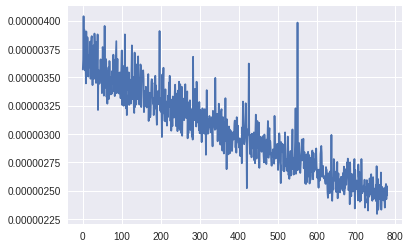

In [25]:
plt.plot(losses)